In [110]:
from dataset1 import *
import numpy as np
from scipy.linalg import solve_triangular 
from numpy.linalg import eigh  # For eigenvalue decomposition of symmetric matrices


## Define functions

In [6]:
def getAprox(A, Omega, rank): 
    """
    Compute a low-rank approximation of the matrix A using 
    Eigenvalue decomposition and truncation.

    Parameters:
        A (numpy.ndarray): Original matrix.
        Omega (numpy.ndarray): Random sketching matrix.
        rank (int): Desired rank for the approximation.

    Returns:
        A_nyst_k (numpy.ndarray): Low-rank approximation of A.
    """
    # Compute sketch matrix C
    C = A @ Omega  # Project A onto the subspace defined by Omega

    # Compute the smaller B matrix
    B = Omega.T @ C  # Compression of A into a smaller matrix via Omega

    # Eigenvalue decomposition of B
    eig_v, V = eigh(B)  # eig_v: Eigenvalues, V: Eigenvectors

    # Truncate eigenvalues and eigenvectors to keep only positive eigenvalues
    truncate = eig_v > 0
    eig_v = eig_v[truncate]
    V = V[:, truncate]

    # Normalize using the eigenvalues to construct Z
    Z = C @ V @ np.diag(1 / np.sqrt(eig_v))  # Normalize columns of C

    # Perform QR decomposition of Z
    Q, R = np.linalg.qr(Z)  # Q: Orthogonal basis, R: Upper triangular matrix

    # Singular Value Decomposition (SVD) of R
    U, Sigma, Vh = np.linalg.svd(R)

    # Construct the low-rank approximation
    U_hat = Q @ U[:, :rank]  # Truncate U to the desired rank
    A_nyst_k = U_hat @ np.diag(Sigma[:rank]**2) @ U_hat.T  # Final approximation

    return A_nyst_k


def getAprox2(A, Omega, rank): 
    """
    Compute a low-rank approximation of the matrix A using Cholesky 
    decomposition with regularization.

    Parameters:
        A (numpy.ndarray): Original matrix.
        Omega (numpy.ndarray): Random sketching matrix.
        rank (int): Desired rank for the approximation.

    Returns:
        A_nyst_k (numpy.ndarray): Low-rank approximation of A.
    """
    # Compute sketch matrix C
    C = A @ Omega

    # Regularization term based on the norm of C
    nu = 1e-18 * np.linalg.norm(C)  # Very small regularization term

    # Apply regularization to C
    C_shifted = C + nu * Omega

    # Compute the smaller B matrix
    B = Omega.T @ C_shifted

    # Perform Cholesky decomposition of B
    L = np.linalg.cholesky(B)  # L is a lower triangular matrix

    # Solve for Z using the triangular solver
    Z = solve_triangular(L, C_shifted.T, lower=True).T  # Z = C @ L^-T

    # Perform QR decomposition of Z
    Q, R = np.linalg.qr(Z)

    # Singular Value Decomposition (SVD) of R
    U, Sigma, Vh = np.linalg.svd(R)

    # Construct the low-rank approximation
    U_hat = Q @ U[:, :rank]  # Truncate U to the desired rank
    A_nyst_k = U_hat @ (np.diag(Sigma[:rank]**2) - nu * np.eye(rank)) @ U_hat.T  # Adjust with regularization

    return A_nyst_k


def getError(A, A_k):
    """
    Compute the relative error between the original matrix A 
    and its low-rank approximation A_k.

    Parameters:
        A (numpy.ndarray): Original matrix.
        A_k (numpy.ndarray): Low-rank approximation of A.

    Returns:
        float: Relative error in the nuclear norm.
    """
    # Compute the relative error using the nuclear norm
    return np.linalg.norm(A - A_k, ord='nuc') / np.linalg.norm(A, ord='nuc')



## Tests

In [40]:
n = 1024
l = 128
A = getExpMatrix(n)
Omega = np.random.normal(size=(n,l)) #Sketch matrix

In [ ]:
import numpy as np

# Dictionary to store the errors
errors = {}

# Define sketch sizes and their proportional steps
sketch_dims = np.linspace(100, 1000, 10, dtype=int)  # E.g., 100 to 1000, 10 values

for sketch_dim in sketch_dims:
    errors[sketch_dim] = {}
    
    # Adjust ranks proportional to sketch_dim
    ranks = np.linspace(10, sketch_dim - 10, 10, dtype=int)  # 10 ranks proportional to sketch_dim
    
    for rank in ranks:
        # Compute the approximation for the given sketch_dim and rank
        aprox = getAprox(A, Omega[:, :sketch_dim], rank)
        
        # Compute the error between the original matrix and the approximation
        err = getError(A, aprox)
        
        # Store the error
        errors[sketch_dim][rank] = err


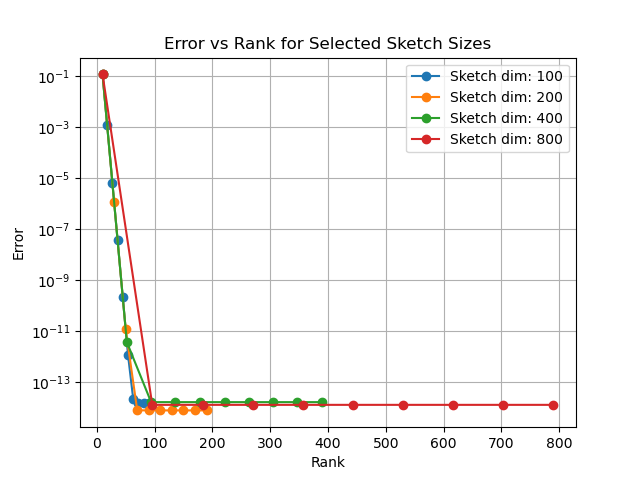

In [32]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.close('all')
# Subset of sketch dimensions to plot
selected_sketch_dims = [100,200,400,800]  # Replace with the sketch dimensions you want to plot

# Plot only the selected dimensions
for sketch_dim, rank_errors in errors.items():
    if sketch_dim in selected_sketch_dims:  # Filter based on condition
        ranks = list(rank_errors.keys())
        errs = list(rank_errors.values())
        plt.plot(ranks, errs,'-o', label=f'Sketch dim: {sketch_dim}')

plt.xlabel('Rank')
plt.ylabel('Error')
plt.yscale('log')
plt.title('Error vs Rank for Selected Sketch Sizes')
plt.legend()
plt.grid(True)
plt.show()


We can see that we achieve min error from rank 70. Let's study effect of sketch size with constant rank

In [33]:
new_errors = {}
for sketch_dim in range(70,100):
    prox = getAprox(A, Omega[:, :sketch_dim], 70) # for rank 70 
        
    # Compute the error between the original matrix and the approximation
    err = getError(A, aprox)
    # Store the error
    new_errors[sketch_dim] = err

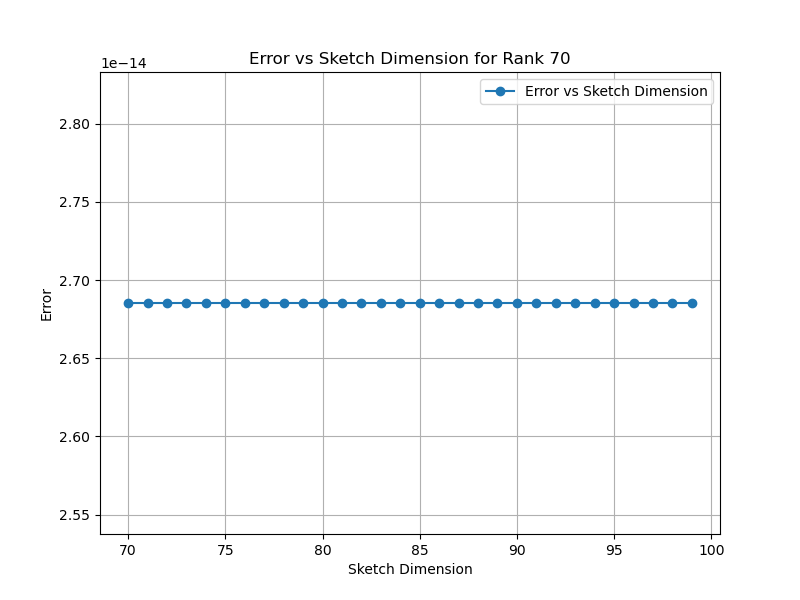

In [34]:
import matplotlib.pyplot as plt

# Assuming new_errors is already computed
# Example structure: {70: 0.1, 71: 0.08, ..., 99: 0.02}

# Extract keys (sketch dimensions) and values (errors)
sketch_dims = list(new_errors.keys())
errors = list(new_errors.values())

# Plot the error vs sketch dimension
plt.figure(figsize=(8, 6))
plt.plot(sketch_dims, errors, '-o', label='Error vs Sketch Dimension')  # Line with markers

# Add labels, title, and grid
plt.xlabel('Sketch Dimension')
plt.ylabel('Error')
plt.title('Error vs Sketch Dimension for Rank 70')
plt.grid(True)
plt.legend()
plt.show()


In [109]:
A_lowrank = getLowRank(A,Omega,rank=128,l=256,method='fjlt')
print(getError(A,A_lowrank))

4.0
4.0
165312.26052739652


## FSJH

In [ ]:
import numpy as np

def fht(x):
    """
    Applique la normalized Fast Hadamard Transform à x sans boucles Python explicites.
    x: tableau NumPy de forme (..., n), où n est une puissance de 2.
    """
    n = x.shape[-1]
    assert (n & (n - 1) == 0), "La taille de x doit être une puissance de 2"
    x = x.copy()
    h = 1
    while h < n:
        # Redimensionne x pour les opérations vectorisées
        x = x.reshape(-1, n // (2 * h), 2 * h)
        # Effectue les opérations de Hadamard
        a = x[:, :, :h]
        b = x[:, :, h:2*h]
        x = np.concatenate([a + b, a - b], axis=2)
        h *= 2
    # Restaure la forme originale
    x = x.reshape(-1, n)/np.sqrt(n)
    return x

def fjlt(A, D, indices, direction):
    """
    Applique la Fast Johnson-Lindenstrauss Transform sur une matrice carrée.

    Paramètres:
    - D: vecteur diagonal de +1 et -1 (tableau NumPy de taille n)
    - indices: indices des lignes/colonnes sélectionnées
    - axis: 'rows' pour travailler sur les lignes, 'columns' pour les colonnes
    """
    n , m = A.shape
    l = indices.shape[0] #Sketch size
    if direction == 'left': # FJHT from the left
        assert len(D) == n, "La longueur de D doit être égale au nombre de lignes de A"
        assert (n & (n - 1) == 0), "Le nombre de lignes de A doit être une puissance de 2"
        # Multiplie chaque ligne de A par D_i
        A_tilde = A * D[:,np.newaxis]
        # Applique la Fast Hadamard Transform sur chaque ligne
        A_fht = fht(A_tilde)
        # Subsample les lignes
        A_proj = A_fht[indices,:]*np.sqrt(n/l)

    elif direction== 'right': # Transposed FJHT from the right

        # Multiplie chaque colonne de A par D
        A_tilde = A * D[np.newaxis,:]
        # Transpose pour appliquer la FHT sur les colonnes
        A_fht = fht(A_tilde.T).T
        # Subsample les colonnes
        A_proj = A_fht[:,indices] * np.sqrt(n/l)
    return A_proj


In [111]:
def getLowRank(A, Omega, rank ,l,method='gaussian'): 
    """
    Compute a low-rank approximation of the matrix A using 
    Eigenvalue decomposition and truncation.

    Parameters:
        A (numpy.ndarray): Original matrix.
        Omega (numpy.ndarray): Random sketching matrix.
        rank (int): Desired rank for the approximation.

    Returns:
        A_nyst_k (numpy.ndarray): Low-rank approximation of A.
    """
    m = A.shape[0]
    B = None
    C = None

    if method == 'fjlt': #If not gaussian sketching use Fast Johnson-Lindenstrauss transform to sketch
        D = np.random.choice([1, -1], size=m)
        indices = np.random.choice(m, size=l, replace=False) # Subsample
        C = fjlt(A,D,indices,direction='right')
        B = fjlt(C,D,indices,direction='left')
    elif method == 'gaussian': # Use gaussian matrix to sketch
        # Compute sketch matrix C
        C = A @ Omega  # Project A onto the subspace defined by Omega
        # Compute the smaller B matrix
        B = Omega.T @ C  # Compression of A into a smaller matrix via Omega
    else:
        return None
    
    # Eigenvalue decomposition of B
    eig_v, V = eigh(B)  # eig_v: Eigenvalues, V: Eigenvectors

    # Truncate eigenvalues and eigenvectors to keep only positive eigenvalues
    truncate = eig_v > 1e-10
    eig_v = eig_v[truncate]
    V = V[:, truncate]

    # Normalize using the eigenvalues to construct Z
    Z = C @ V @ np.diag(1 / np.sqrt(eig_v))  # Normalize columns of C

    # Perform QR decomposition of Z
    Q, R = np.linalg.qr(Z)  # Q: Orthogonal basis, R: Upper triangular matrix

    # Singular Value Decomposition (SVD) of R
    U, Sigma, Vh = np.linalg.svd(R)

    # Construct the low-rank approximation
    U_hat = Q @ U[:, :rank]  # Truncate U to the desired rank
    A_nyst_k = U_hat @ np.diag(Sigma[:rank]**2) @ U_hat.T  # Final approximation

    return A_nyst_k
